In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

In [ ]:

def calculate_angle(p1, p2, p3):
    """
    Calculate the angle at p2 formed by the line segments p1-p2 and p3-p2.
    Arguments:
    - p1, p2, p3: Arrays or lists containing the coordinates [x, y, z].
    Returns:
    - Angle in degrees.
    """
    # Create vectors
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)

    # Calculate the dot product and magnitudes
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)

    # Avoid division by zero
    if magnitude_v1 == 0 or magnitude_v2 == 0:
        return None

    # Calculate the angle in radians
    angle_radians = np.arccos(dot_product / (magnitude_v1 * magnitude_v2))
    # Convert to degrees
    angle_degrees = np.degrees(angle_radians)
    return angle_degrees

# Load the CSV
input_file = "merged_output.csv"
output_file = "output_with_angles.csv"

# Columns for the joints
columns = {
    "LEFT_HIP": ["LEFT_HIP_x", "LEFT_HIP_y", "LEFT_HIP_z"],
    "LEFT_KNEE": ["LEFT_KNEE_x", "LEFT_KNEE_y", "LEFT_KNEE_z"],
    "LEFT_ANKLE": ["LEFT_ANKLE_x", "LEFT_ANKLE_y", "LEFT_ANKLE_z"],
    "RIGHT_HIP": ["RIGHT_HIP_x", "RIGHT_HIP_y", "RIGHT_HIP_z"],
    "RIGHT_KNEE": ["RIGHT_KNEE_x", "RIGHT_KNEE_y", "RIGHT_KNEE_z"],
    "RIGHT_ANKLE": ["RIGHT_ANKLE_x", "RIGHT_ANKLE_y", "RIGHT_ANKLE_z"],
}

# Read the data
df = pd.read_csv(input_file)

# Calculate angles for each frame
angles = []
for _, row in df.iterrows():
    left_knee_angle = calculate_angle(
        row[columns["LEFT_HIP"]], 
        row[columns["LEFT_KNEE"]], 
        row[columns["LEFT_ANKLE"]]
    )
    right_knee_angle = calculate_angle(
        row[columns["RIGHT_HIP"]], 
        row[columns["RIGHT_KNEE"]], 
        row[columns["RIGHT_ANKLE"]]
    )
    angles.append({"LEFT_KNEE_ANGLE": left_knee_angle, "RIGHT_KNEE_ANGLE": right_knee_angle})

# Add angles to the DataFrame
angles_df = pd.DataFrame(angles)
result_df = pd.concat([df, angles_df], axis=1)

# Save to a new CSV
result_df.to_csv(output_file, index=False)
print(f"Processed data saved to {output_file}")


Processed data saved to output_with_angles.csv


In [3]:
movement_data = pd.read_csv("output_with_angles.csv")
movement_data

,frame,LEFT_ANKLE_x,LEFT_EAR_x,LEFT_ELBOW_x,LEFT_EYE_x,LEFT_EYE_INNER_x,LEFT_EYE_OUTER_x,LEFT_FOOT_INDEX_x,LEFT_HEEL_x,LEFT_HIP_x,...,RIGHT_INDEX_z,RIGHT_KNEE_z,RIGHT_PINKY_z,RIGHT_SHOULDER_z,RIGHT_THUMB_z,RIGHT_WRIST_z,annotation,videoid,LEFT_KNEE_ANGLE,RIGHT_KNEE_ANGLE
0,0,0.526178,0.454818,0.579769,0.435435,0.424799,0.445332,0.570951,0.513027,0.484337,...,0.210203,0.493727,0.236498,0.325306,0.253600,0.266685,Still,bapproach1,136.862273,130.945609
1,1,0.525655,0.454755,0.579388,0.435266,0.424666,0.444514,0.567500,0.512050,0.484133,...,0.220754,0.494478,0.247105,0.331144,0.262427,0.275492,Still,bapproach1,134.261522,130.383060
2,2,0.524938,0.453879,0.578138,0.434714,0.423830,0.443160,0.565493,0.510918,0.481966,...,0.220191,0.494378,0.245681,0.328713,0.261951,0.274716,Still,bapproach1,133.427105,130.180025
3,3,0.524238,0.450395,0.576506,0.433364,0.421889,0.441080,0.564397,0.510423,0.479499,...,0.205395,0.496902,0.231729,0.321172,0.248262,0.261434,Still,bapproach1,133.931554,131.060877
4,4,0.523820,0.446120,0.572280,0.429352,0.417237,0.437730,0.564309,0.509886,0.475675,...,0.203967,0.500852,0.229942,0.321479,0.246645,0.259679,Still,bapproach1,134.559533,133.379099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7582,75,0.655740,0.493633,0.835403,0.442184,0.420509,0.462624,0.764315,0.626971,0.614757,...,0.313152,0.751724,0.338444,0.450269,0.361474,0.374412,stand,sstand2,143.144608,151.472893
7583,76,0.655860,0.492817,0.823598,0.441257,0.419645,0.462477,0.764197,0.625224,0.607706,...,0.347895,0.766156,0.373864,0.482316,0.396372,0.409577,stand,sstand2,145.402732,154.524642
7584,77,0.655866,0.486263,0.813894,0.438623,0.418643,0.460635,0.764177,0.622663,0.600839,...,0.361718,0.745588,0.388165,0.502106,0.410555,0.423952,stand,sstand2,141.881191,150.581242
7585,78,0.656129,0.478312,0.798870,0.435743,0.417290,0.457135,0.764033,0.622570,0.595394,...,0.372646,0.740648,0.398608,0.511323,0.421087,0.434140,stand,sstand2,139.863571,149.718221


In [4]:
from scipy.signal import butter, filtfilt, savgol_filter

# Crear los coeficientes del filtro Butterworth
b, a = butter(N=3, Wn=0.933333, btype='low')

# Inicializar DataFrames finales para los datos filtrados y suavizados
filtered_dataset = movement_data.copy()
smoothed_dataset = movement_data.copy()

# Obtener los IDs únicos de los videos
video_ids = movement_data["videoid"].unique()

# Procesar cada video
for video_id in video_ids:
    # Filtrar los datos por el ID del video actual
    video_data = movement_data[movement_data["videoid"] == video_id]
    
    # Identificar columnas numéricas (exceptuando 'frame')
    numeric_columns = video_data.select_dtypes(include=['number']).columns
    columns_to_filter = [col for col in numeric_columns if col != 'frame']

    # Crear copia de los datos originales para aplicar los filtros
    filtered_data = video_data.copy()

    # Aplicar el filtro Butterworth a las columnas seleccionadas
    for column in columns_to_filter:
        filtered_data[column] = filtfilt(b, a, video_data[column])

    # Crear copia para aplicar el filtro Savitzky-Golay
    smoothed_data = filtered_data.copy()
    for column in columns_to_filter:
        smoothed_data[column] = savgol_filter(filtered_data[column], window_length=11, polyorder=3)

    # Reemplazar los datos filtrados y suavizados en los DataFrames finales
    filtered_dataset.loc[video_data.index, columns_to_filter] = filtered_data[columns_to_filter]
    smoothed_dataset.loc[video_data.index, columns_to_filter] = smoothed_data[columns_to_filter]


C:\Users\juans\AppData\Local\Temp\ipykernel_45236\3758283437.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_id_data['SHOULDER_DISTANCE_x'] = abs(video_id_data['LEFT_SHOULDER_x'] - video_id_data['RIGHT_SHOULDER_x'])
C:\Users\juans\AppData\Local\Temp\ipykernel_45236\3758283437.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_id_data_filtered['SHOULDER_DISTANCE_x'] = abs(video_id_data_filtered['LEFT_SHOULDER_x'] - video_id_data_filtered['RIGHT_SHOULDER_x'])
C:\Users\juans\AppData\Local\Temp

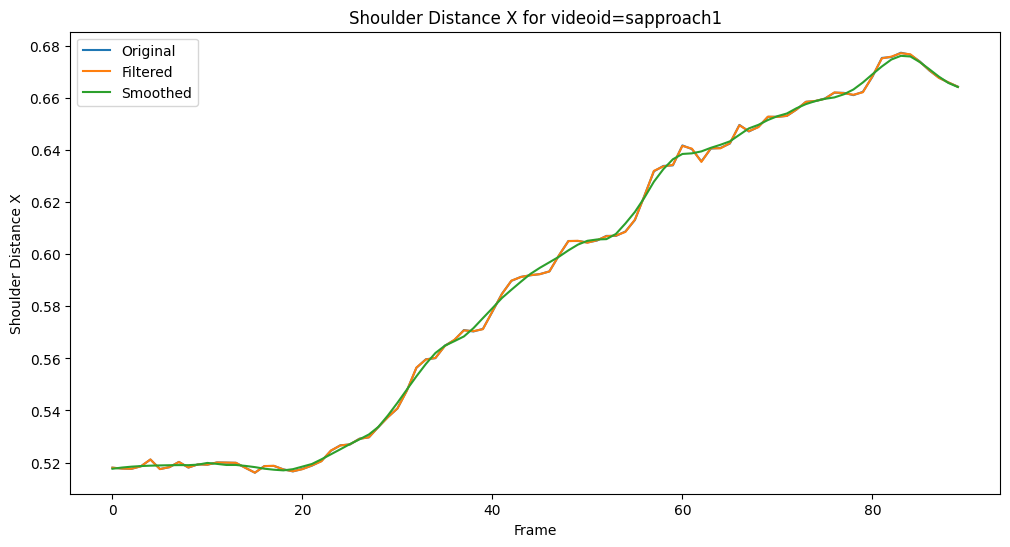

In [5]:
video_id_data = movement_data[movement_data["videoid"] == "sapproach1"]
video_id_data_filtered = filtered_dataset[filtered_dataset["videoid"] == "sapproach1"]
video_id_data_smoothed = smoothed_dataset[smoothed_dataset["videoid"] == "sapproach1"]

video_id_data['SHOULDER_DISTANCE_x'] = abs(video_id_data['LEFT_SHOULDER_x'] - video_id_data['RIGHT_SHOULDER_x'])
video_id_data_filtered['SHOULDER_DISTANCE_x'] = abs(video_id_data_filtered['LEFT_SHOULDER_x'] - video_id_data_filtered['RIGHT_SHOULDER_x'])
video_id_data_smoothed['SHOULDER_DISTANCE_x'] = abs(video_id_data_smoothed['LEFT_SHOULDER_x'] - video_id_data_smoothed['RIGHT_SHOULDER_x']) 

plt.figure(figsize=(12, 6))
plt.plot(video_id_data["frame"], video_id_data["SHOULDER_DISTANCE_x"], label="Original")
plt.plot(video_id_data_filtered["frame"], video_id_data_filtered["SHOULDER_DISTANCE_x"], label="Filtered")
plt.plot(video_id_data_smoothed["frame"], video_id_data_smoothed["SHOULDER_DISTANCE_x"], label="Smoothed")
plt.xlabel('Frame')
plt.ylabel('Shoulder Distance X')
plt.title('Shoulder Distance X for videoid=sapproach1')
plt.legend()
plt.show()


In [15]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

#Model for smoothed
y = smoothed_dataset['annotation']
x = smoothed_dataset.drop(['annotation', 'videoid', 'frame'], axis=1)

labels = y

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
encoded_labels = label_encoder.fit_transform(labels)

# Print the mapping and the encoded labels
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping:", label_mapping)
print("Encoded Labels:", encoded_labels)

Label Mapping: {'Still': 0, 'approach': 1, 'back': 2, 'jump': 3, 'sit': 4, 'stand': 5, 'turn_left': 6, 'turn_right': 7, 'walk_left': 8, 'walk_right': 9}
Encoded Labels: [0 0 0 ... 5 5 5]


In [18]:
# Normalized
x = movement_data.drop(['annotation', 'videoid', 'frame'], axis=1)  

X_train, X_test, y_train, y_test = train_test_split(x, encoded_labels, test_size=0.2, random_state=42)

model = XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9769433465085638


In [17]:
# Normalized + Filtered 
x = filtered_dataset.drop(['annotation', 'videoid', 'frame'], axis=1)  

X_train, X_test, y_train, y_test = train_test_split(x, encoded_labels, test_size=0.2, random_state=42)

model = XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9756258234519104


In [21]:
# Normalized + Filtered + Smoothed
x = smoothed_dataset.drop(['annotation', 'videoid', 'frame'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, encoded_labels, test_size=0.2, random_state=42)

model = XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9789196310935442


In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Asegúrate de que 'x' y 'encoded_labels' están correctamente definidos
x = smoothed_dataset.drop(['annotation', 'videoid', 'frame'], axis=1)

# Divide los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(x, encoded_labels, test_size=0.2, random_state=42)

# Define el modelo
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define los hiperparámetros para GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Configura GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',  # Métrica de evaluación
    cv=3,  # Número de folds para validación cruzada
    verbose=1,  # Nivel de detalle en la salida
    n_jobs=-1  # Usa todos los núcleos disponibles
)

# Ejecuta GridSearchCV
grid_search.fit(X_train, y_train)

# Obtén los mejores parámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Evalúa el modelo con los mejores parámetros
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calcula la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy con los mejores hiperparámetros: {accuracy}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits


c:\Users\juans\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
6 fits failed out of a total of 729.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\juans\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\juans\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\juans\AppData\Local\Programs\Python\Python312\Lib\site-package

Mejores hiperparámetros: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150, 'subsample': 1.0}
Accuracy con los mejores hiperparámetros: 0.9802371541501976


In [24]:
import pickle

# Exporta el mejor modelo a un archivo
with open('best_xgb_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Modelo exportado exitosamente como 'best_xgb_model.pkl'")

Modelo exportado exitosamente como 'best_xgb_model.pkl'


In [25]:
#Cargar modelo
"""
import pickle

# Carga el modelo desde el archivo
with open('best_xgb_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Usa el modelo cargado para hacer predicciones
y_pred_new = loaded_model.predict(X_test)
print("Predicciones usando el modelo cargado:", y_pred_new)
"""

'\nimport pickle\n\n# Carga el modelo desde el archivo\nwith open(\'best_xgb_model.pkl\', \'rb\') as file:\n    loaded_model = pickle.load(file)\n\n# Usa el modelo cargado para hacer predicciones\ny_pred_new = loaded_model.predict(X_test)\nprint("Predicciones usando el modelo cargado:", y_pred_new)\n'